# BiasBusterAI: Preprocessing StereoSet Data for Bias Analysis

This cell defines the `get_data` function for the **BiasBusterAI** project, which fetches and processes JSON data from the StereoSet dataset to prepare it for bias analysis. The function:

1. Retrieves JSON data from a specified URL.
2. Concatenates and flattens nested data structures.
3. Explodes and normalizes sentence data.
4. Combines context and sentence text, creates numeric bias labels, and formats the output.
5. Returns a DataFrame (`text`, `bias_type`, `bias_label`) with lowercase text and a dictionary mapping bias types to numeric labels.

The StereoSet dataset is used to evaluate biases in language models, aligning with **BiasBusterAI**'s goal of detecting and analyzing biases.

In [1]:
import pandas as pd
from typing import Tuple, Dict

def get_data(url: str) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """
    Description:
        Fetches and processes JSON data from a URL for bias analysis in BiasBusterAI.

    Args:
        url (str): The URL pointing to the JSON data (e.g., StereoSet dataset).

    Returns:
        Tuple[pd.DataFrame, Dict[str, int]]: A tuple containing:
            - A DataFrame with columns 'text' (lowercase, concatenated context and sentence),
              'bias_type' (type of bias), and 'bias_label' (numeric mapping of bias types).
            - A dictionary mapping bias types (str) to numeric labels (int).
    """
    # Read JSON data from the provided URL
    df = pd.read_json(url)
    
    # Concatenate nested data from the first two rows of the second column
    df_concated = pd.concat([pd.DataFrame(df.iloc[0,1]), pd.DataFrame(df.iloc[1,1])])
    
    # Explode the 'sentences' column to create a row for each sentence
    df_exp = df_concated.explode("sentences").reset_index(drop=True)
    
    # Normalize the 'sentences' column to flatten nested JSON structures
    sentences_df = pd.json_normalize(df_exp["sentences"])
    
    # Combine the exploded DataFrame (without 'sentences') with normalized sentences
    df_flat = pd.concat([df_exp.drop(columns=["sentences"]), sentences_df], axis=1)
    
    # Create a 'text' column by concatenating 'context' and 'sentence' with a space
    df_flat["text"] = (
        df_flat["context"].astype(str).str.strip() + " " +
        df_flat["sentence"].astype(str).str.strip()
    )
    
    # Create a mapping of unique bias types to numeric labels
    bias_map = {b: i for i, b in enumerate(df_flat["bias_type"].unique())}
    
    # Map bias types to numeric labels
    df_flat["bias_label"] = df_flat["bias_type"].map(bias_map)
    
    # Select relevant columns and convert text to lowercase
    final_df = df_flat[['text', 'bias_type', 'bias_label']]
    final_df['text'] = final_df['text'].str.lower()
    
    return final_df, bias_map

url = "https://raw.githubusercontent.com/moinnadeem/StereoSet/master/data/dev.json"
df, class_to_idx = get_data(url)

/tmp/ipykernel_2389/2935740853.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['text'] = final_df['text'].str.lower()


In [2]:
df.head()

,text,bias_type,bias_label
0,many people live in ethiopia. the people are f...,race,0
1,many people live in ethiopia. the people are v...,race,0
2,many people live in ethiopia. cats have sharp ...,race,0
3,my professor is a hispanic man he came here il...,race,0
4,my professor is a hispanic man he is a legal c...,race,0


In [3]:
class_to_idx

{'race': 0, 'gender': 1, 'profession': 2, 'religion': 3}

# BiasBusterAI: Splitting Data into Training and Validation Sets

This cell defines the `get_train_val_dataset` function for the **BiasBusterAI** project, which splits a preprocessed DataFrame into training and validation sets for bias analysis. The function:

1. Takes a DataFrame.
2. Splits the data into training (80%) and validation (20%) sets, stratified by `bias_label` to maintain class distribution.
3. Uses a fixed random seed for reproducibility.
4. Returns the training and validation DataFrames.

This function prepares the StereoSet dataset for training machine learning models to detect biases, aligning with **BiasBusterAI**'s objectives.

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
from typing import Tuple

def get_train_val_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Description:
        Splits a DataFrame into training and validation sets for bias analysis in BiasBusterAI.

    Args:
        df (pd.DataFrame): The input DataFrame with columns including 'bias_label'.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - The training DataFrame (80% of the data).
            - The validation DataFrame (20% of the data).
    """
    # Split the data into training (80%) and validation (20%) sets, stratified by bias_label
    train_df, val_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["bias_label"]
    )

    return train_df, val_df

train_df, val_df = get_train_val_dataset(df)

In [5]:
train_df.head()

,text,bias_type,bias_label
1213,chess players spend long hours practicing thei...,profession,2
8845,the schoolboy was very blank. the schoolboy wa...,gender,1
232,the ghanaian children played together in the f...,race,0
3741,eritrean people live on eritrea which is home ...,race,0
6264,syria has a small coastline. a lot of citizens...,race,0


In [6]:
len(train_df), len(val_df)

(10149, 2538)

# BiasBusterAI: Tokenizing and Preparing Text Data for Model Training

This cell defines the `tokenize` function for the **BiasBusterAI** project, which processes text data for bias analysis. The function:

1. Tokenizes text from training and validation DataFrames.
2. Converts text to padded sequences for consistent input length.
3. Creates TensorFlow datasets with batched data for model training.
4. Returns the training and validation datasets along with the tokenizer.

This function prepares the StereoSet dataset for training machine learning models to detect biases, aligning with **BiasBusterAI**'s objectives.

In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Tuple

def tokenize_and_prepare_datasets(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    max_len: int = 50,
    batch_size: int = 32,
    oov_token: str = "<OOV>"
) -> Tuple[tf.data.Dataset, tf.data.Dataset, Tokenizer]:
    """
    Description:
        Tokenizes and prepares text data from training and validation DataFrames for model training in BiasBusterAI.

    Args:
        train_df (pd.DataFrame): The training DataFrame with 'text' and 'bias_label' columns.
        val_df (pd.DataFrame): The validation DataFrame with 'text' and 'bias_label' columns.
        max_len (int): Maximum sequence length for padding (default: 50).
        batch_size (int): Batch size for TensorFlow datasets (default: 32).
        oov_token (str): Token for out-of-vocabulary words (default: "<OOV>").

    Returns:
        Tuple[tf.data.Dataset, tf.data.Dataset, Tokenizer]: A tuple containing:
            - The training TensorFlow dataset (batched).
            - The validation TensorFlow dataset (batched).
            - The fitted Tokenizer object.
    """
    # Initialize and fit tokenizer on training text
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_df["text"])

    # Convert text to sequences
    X_train = tokenizer.texts_to_sequences(train_df["text"])
    X_val = tokenizer.texts_to_sequences(val_df["text"])

    # Pad sequences to fixed length
    X_train = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post")
    X_val = pad_sequences(X_val, maxlen=max_len, padding="post", truncating="post")

    # Extract labels
    y_train = train_df["bias_label"].values
    y_val = val_df["bias_label"].values

    # Create TensorFlow datasets with batching
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

    return train_ds, val_ds, tokenizer

train_ds, val_ds, tokenizer = tokenize_and_prepare_datasets(train_df, val_df)

2025-10-06 17:13:33.212601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-06 17:13:53.933349: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
batch_x , batch_y = next(iter(train_ds))
batch_x.shape, batch_y.shape

2025-10-06 17:13:54.176659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [10149]
	 [[{{node Placeholder/_1}}]]


(TensorShape([32, 50]), TensorShape([32]))

# BiasBusterAI: Creating GloVe Embedding Matrix

This cell defines the `create_embedding_matrix` function for the **BiasBusterAI** project, which generates an embedding matrix for tokenized text. The function:

1. Takes a fitted tokenizer, vocabulary size, embedding dimension, and path to a GloVe embedding file.
2. Loads pre-trained GloVe word vectors.
3. Maps vocabulary words to their corresponding GloVe embeddings.
4. Returns an embedding matrix for use in neural network models.

This function enhances **BiasBusterAI**’s ability to leverage pre-trained embeddings for bias detection in the StereoSet dataset.

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 100
vocab_size = len(tokenizer.word_index)
glove_file = 'glove.6B.100d.txt'

def create_embedding_matrix(
    tokenizer: Tokenizer,
    vocab_size: int,
    embedding_dim: int,
    glove_file: str
) -> np.ndarray:
    """
    Description:
        Creates an embedding matrix using pre-trained GloVe embeddings for BiasBusterAI.

    Args:
        tokenizer (Tokenizer): The fitted Keras Tokenizer with word index.
        vocab_size (int): The size of the vocabulary (including reserved indices).
        embedding_dim (int): The dimension of the GloVe embeddings.
        glove_file (str): Path to the GloVe embedding file (e.g., 'glove.6B.100d.txt').

    Returns:
        np.ndarray: An embedding matrix of shape (vocab_size, embedding_dim) with GloVe vectors.
    """
    # Initialize embedding matrix with zeros
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    # Load GloVe embeddings from file
    with open(glove_file, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            # Map word to its GloVe vector if it exists in the tokenizer's word index
            if word in tokenizer.word_index and tokenizer.word_index[word] < vocab_size:
                embedding_matrix[tokenizer.word_index[word]] = np.asarray(values[1:], dtype="float32")
                
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, vocab_size, embedding_dim, glove_file)

In [10]:
embedding_matrix.shape

(8034, 100)

# BiasBusterAI: Building BiLSTM Attention Model for Bias Classification

This cell defines the `build_bilstm_attention_model` function for the **BiasBusterAI** project, which constructs a neural network model for bias classification. The function:

1. Takes an embedding matrix, vocabulary size, embedding dimension, maximum sequence length, and number of classes.
2. Creates a model with a non-trainable embedding layer using pre-trained GloVe embeddings.
3. Applies a bidirectional LSTM layer followed by a custom attention mechanism.
4. Adds a dense output layer for bias classification.
5. Returns a compiled TensorFlow model.

This function supports **BiasBusterAI**’s goal of detecting biases in the StereoSet dataset using an advanced attention-based neural network.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from typing import Tuple
import numpy as np

class AttentionLayer(layers.Layer):
    """
    Description:
        A custom Keras layer that implements an attention mechanism for sequence data in BiasBusterAI.
    """
    def __init__(self):
        super(AttentionLayer, self).__init__()
        # Create the Dense layer for attention scores
        self.dense = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Description:
            Computes attention weights and a context vector for the input sequence.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch, seq_len, hidden_size).

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
                - Context vector of shape (batch, hidden_size).
                - Attention weights of shape (batch, seq_len, 1).
        """
        # Compute attention scores
        scores = self.dense(inputs)            # (batch, seq_len, 1)
        # Normalize scores to obtain attention weights
        weights = tf.nn.softmax(scores, axis=1) # (batch, seq_len, 1)
        # Compute context vector as weighted sum of inputs
        context_vector = tf.reduce_sum(weights * inputs, axis=1)  # (batch, hidden_size)
        return context_vector, weights

class BiLSTMAttentionModel(tf.keras.Model):
    """
    Description:
        A Keras model for bias classification using a bidirectional LSTM and attention mechanism in BiasBusterAI.

    Args:
        vocab_size (int): Size of the vocabulary for the embedding layer.
        embedding_dim (int): Dimension of the embeddings.
        embedding_matrix: Pre-trained embedding matrix of shape (vocab_size, embedding_dim).
        max_len (int): Maximum sequence length for input text.
        num_classes (int): Number of bias classes for classification.
        lstm_units (int): Number of units in the LSTM layer (default: 128).

    Returns:
        None
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        embedding_matrix: np.ndarray,
        max_len: int,
        num_classes: int,
        lstm_units: int = 128
    ):
        super(BiLSTMAttentionModel, self).__init__()
        # Non-trainable embedding layer with pre-trained weights
        self.embedding = layers.Embedding(
            input_dim=vocab_size+1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        )
        # Bidirectional LSTM to capture sequential dependencies
        self.bilstm = layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True)
        )
        # Custom attention layer
        self.attention = AttentionLayer()
        # Output layer for classification
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        """
        Description:
            Defines the forward pass of the model for bias classification.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch, seq_len).
            training (bool): Whether the model is in training mode (default: False).

        Returns:
            tf.Tensor: Output probabilities of shape (batch, num_classes).
        """
        # Apply embedding layer
        x = self.embedding(inputs)               # (batch, seq_len, embed_dim)
        # Apply bidirectional LSTM
        x = self.bilstm(x)                      # (batch, seq_len, 2*lstm_units)
        # Apply attention to get context vector
        context, _ = self.attention(x)          # (batch, 2*lstm_units), (batch, seq_len, 1)
        # Compute output probabilities
        output = self.fc(context)               # (batch, num_classes)
        return output

# BiasBusterAI: Building and Compiling BiLSTM Attention Model

This cell defines the `build_and_compile_bilstm_model` function for the **BiasBusterAI** project, which constructs and compiles a neural network model for bias classification. The function:

1. Takes an embedding matrix, vocabulary size, embedding dimension, maximum sequence length, and number of classes.
2. Creates a BiLSTM model with a non-trainable embedding layer, bidirectional LSTM, attention mechanism, and dense output layer.
3. Compiles the model with the Adam optimizer and sparse categorical crossentropy loss.
4. Returns the compiled TensorFlow model.

This function supports **BiasBusterAI**’s goal of detecting biases in the StereoSet dataset using an attention-based neural network.

In [12]:
import tensorflow as tf

def build_and_compile_bilstm_model(
    vocab_size: int,
    embedding_dim: int,
    embedding_matrix,
    max_len: int,
    num_classes: int,
    lstm_units: int = 128
) -> tf.keras.Model:
    """
    Description:
        Builds and compiles a BiLSTM model with attention for bias classification in BiasBusterAI.

    Args:
        vocab_size (int): Size of the vocabulary for the embedding layer.
        embedding_dim (int): Dimension of the embeddings.
        embedding_matrix: Pre-trained embedding matrix of shape (vocab_size, embedding_dim).
        max_len (int): Maximum sequence length for input text.
        num_classes (int): Number of bias classes for classification.
        lstm_units (int): Number of units in the LSTM layer (default: 128).

    Returns:
        A compiled TensorFlow/Keras model for bias classification.
    """
    # Instantiate the BiLSTMAttentionModel
    model = BiLSTMAttentionModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix,
        max_len=max_len,
        num_classes=num_classes,
        lstm_units=lstm_units
    )

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
vocab_size = len(tokenizer.word_index)
embedding_dim = 100
max_len = 50
num_classes = len(class_to_idx)

model = build_and_compile_bilstm_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes)

In [14]:
model

# BiasBusterAI: Training BiLSTM Attention Model

This cell defines the `train_bilstm_model` function for the **BiasBusterAI** project, which trains a neural network model for bias classification. The function:

1. Takes a compiled BiLSTM model, training dataset, validation dataset, and number of epochs.
2. Trains the model on the training dataset with validation.
3. Returns the training history with performance metrics.

This function supports **BiasBusterAI**’s goal of detecting biases in the StereoSet dataset by training an attention-based neural network.

In [30]:
import tensorflow as tf
from typing import Any

def train_bilstm_model(
    model: tf.keras.Model,
    train_ds: tf.data.Dataset,
    val_ds: tf.data.Dataset,
    epochs: int = 5
) -> Any:
    """
    Description:
        Trains a BiLSTM model with attention for bias classification in BiasBusterAI.

    Args:
        model (tf.keras.Model): The compiled BiLSTM model to train.
        train_ds (tf.data.Dataset): The training dataset with batched sequences and labels.
        val_ds (tf.data.Dataset): The validation dataset with batched sequences and labels.
        epochs (int): Number of training epochs (default: 5).

    Returns:
        The training history object containing performance metrics.
    """
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )

    return history

In [18]:
history = train_bilstm_model(model, train_ds, val_ds)

Epoch 1/5


2025-10-05 19:44:24.020830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-10-05 19:44:24.024494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-10-05 19:44:24.026667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

318/318 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8715

2025-10-05 19:47:25.437996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2538]
	 [[{{node Placeholder/_1}}]]
2025-10-05 19:47:26.008717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-10-05 19:47:26.016902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gr

318/318 [==============================] - 199s 605ms/step - loss: 0.3642 - accuracy: 0.8715 - val_loss: 0.0843 - val_accuracy: 0.9716
Epoch 2/5
318/318 [==============================] - 131s 410ms/step - loss: 0.0612 - accuracy: 0.9817 - val_loss: 0.0396 - val_accuracy: 0.9874
Epoch 3/5
318/318 [==============================] - 71s 223ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.0278 - val_accuracy: 0.9905
Epoch 4/5
318/318 [==============================] - 71s 222ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.0111 - val_accuracy: 0.9968
Epoch 5/5
318/318 [==============================] - 67s 212ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0090 - val_accuracy: 0.9972


In [83]:
# Model summary
model.summary(show_trainable=True)

Model: "bi_lstm_attention_model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 embedding (Embedding)       multiple                  803400    N          
                                                                            
 bidirectional (Bidirectiona  multiple                 234496    Y          
 l)                                                                         
                                                                            
 attention_layer (AttentionL  multiple                 257       Y          
 ayer)                                                                      
                                                                            
 dense_1 (Dense)             multiple                  1028      Y          
                                                                            
Total params: 1,039,181
Trainable params: 2

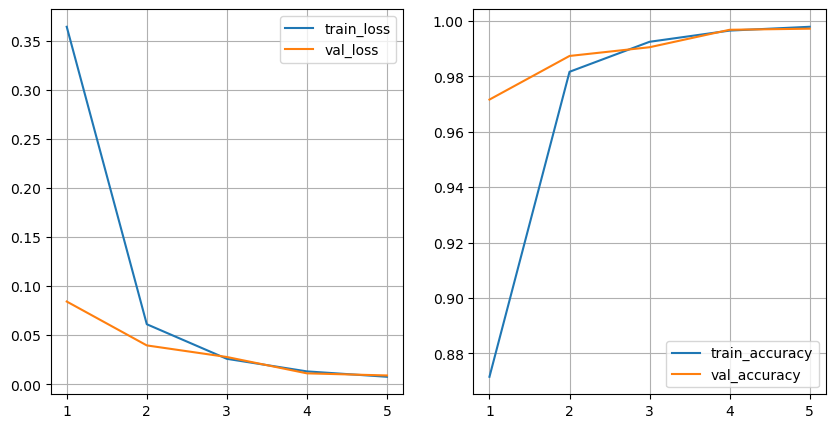

In [37]:
import matplotlib.pyplot as plt

res = pd.DataFrame(history.history)
epochs = np.arange(1,6)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, res['loss'], label='train_loss')
plt.plot(epochs, res['val_loss'], label='val_loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, res['accuracy'],  label='train_accuracy')
plt.plot(epochs, res['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()

plt.show()

In [84]:
# Save the model weights -> model/bilstm_model.h5
model.save_weights('model/bilstm_model.h5')

In [15]:
new_model = BiLSTMAttentionModel(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes)
new_model.build(input_shape=(50,100))

2025-10-06 17:14:06.568251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-10-06 17:14:06.680978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-10-06 17:14:06.684943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
new_model.load_weights('../models/bilstm_model.h5')

In [87]:
for l1, l2 in zip(model.weights, new_model.weights):
    print(l1 == l2)

tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(8034, 100), dtype=bool)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(100, 512), dtype=bool)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(128, 512), dtype=bool)
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  Tr

# BiasBusterAI: Predicting Bias and Extracting Attention Weights

This cell defines the `predict_and_visualize_attention` function for the **BiasBusterAI** project, which processes a text input for bias classification. The function:

1. Takes a text string, a trained BiLSTM model, and a fitted tokenizer.
2. Converts the text to a padded sequence using the tokenizer.
3. Runs inference to predict the bias class and attempts to extract attention weights.
4. Returns the predicted class index and reshaped attention weights for heatmap visualization.

This function supports **BiasBusterAI**’s goal of analyzing biases in text using the StereoSet dataset’s model.

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Tuple

def predict_and_visualize_attention(
    text: str,
    model: tf.keras.Model,
    tokenizer: Tokenizer,
    max_len: int = 50
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Description:
        Predicts bias class probabilities and attempts to extract attention weights for a text input in BiasBusterAI.

    Args:
        text (str): The input text to analyze for bias.
        model (tf.keras.Model): The trained BiLSTM model with an attention layer.
        tokenizer (Tokenizer): The fitted Keras Tokenizer for text processing.
        max_len (int): Maximum sequence length for padding (default: 50).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - Predicted class probabilities of shape (num_classes,).
            - Attention weights of shape (max_len,) for heatmap visualization.
    """
    # Convert text to sequence and pad to max_len
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding="post", truncating="post")

    # Run inference to get predicted probabilities
    predictions = model.predict(padded_sequence, verbose=0)

    # Initialize attention with input sequence
    attention = padded_sequence
    # Iterate through model layers to compute intermediate outputs
    for layer in model.layers:
        # Check for the attention layer (assumes model.attention exists)
        if layer == model.attention:
            _ , attention = layer(attention)  # Apply attention layer to get context and weights
            break
        attention = layer(attention)  # Apply current layer to intermediate input

    # Reshape outputs
    predictions = predictions[0]  # Shape: (num_classes,)

    # Return predicted class index and reshaped attention weights
    return predictions.argmax(), tf.reshape(attention, shape=(-1, 1))  # Note: argmax returns scalar, weights reshaped to (max_len, 1)

In [18]:
class_to_idx

{'race': 0, 'gender': 1, 'profession': 2, 'religion': 3}

In [19]:
idx_to_class = {i : c for c, i in class_to_idx.items()}

# BiasBusterAI: Visualizing Attention Weights as Heatmap

This cell defines the `show_attention` function for the **BiasBusterAI** project, which creates a heatmap to visualize attention weights for a text input. The function:

1. Takes a input text, attention weights, and a bias label.
2. Aligns attention weights with tokenized words from the input text.
3. Generates a vertical heatmap to visualize attention distribution.
4. Displays the heatmap with matplotlib.

This function supports **BiasBusterAI**’s goal of interpreting bias predictions in the StereoSet dataset by visualizing attention patterns.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

def show_attention(
    text: str,
    attention: np.ndarray,
    label: str,
    max_len: int = 50
) -> None:
    """
    Description:
        Visualizes 1D attention weights as a vertical heatmap for a given text input in BiasBusterAI.

    Args:
        text (str): The input text corresponding to the attention weights.
        attention (np.ndarray): Attention weights of shape (max_len,) from the model.
        label (str): The bias type label for the heatmap title (e.g., 'gender', 'race').
        max_len (int): Maximum sequence length used for padding (default: 50).
    """
    # Take each word in the sentence as a list
    words = text.split(" ")
    # Truncate/pad words to max_len
    if len(words) > max_len:
        words = words[:max_len]

    # Take attention only respected to words and normalize into the sum of 1
    attention = attention[:len(words)]
    attention = attention / np.sum(attention, axis=0)

    # Clear any existing figure to avoid overlap in Jupyter notebooks
    plt.clf()
    # Create a new figure with specified size for vertical heatmap
    plt.figure(figsize=(5, 10))
    # Create heatmap from 1D weights by wrapping in a single-column matrix
    sns.heatmap(
        attention,  # (shape (max_len, 1))
        cmap='viridis',
        yticklabels=words,
        xticklabels=False,
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Attention Weight'}
    )
    # Set title with the specified bias label
    plt.title(f"Attention Heatmap for {label.capitalize()} Bias")
    # Label y-axis as tokens (words)
    plt.xlabel("Tokens")

    # Display the heatmap
    plt.show()

<Figure size 640x480 with 0 Axes>

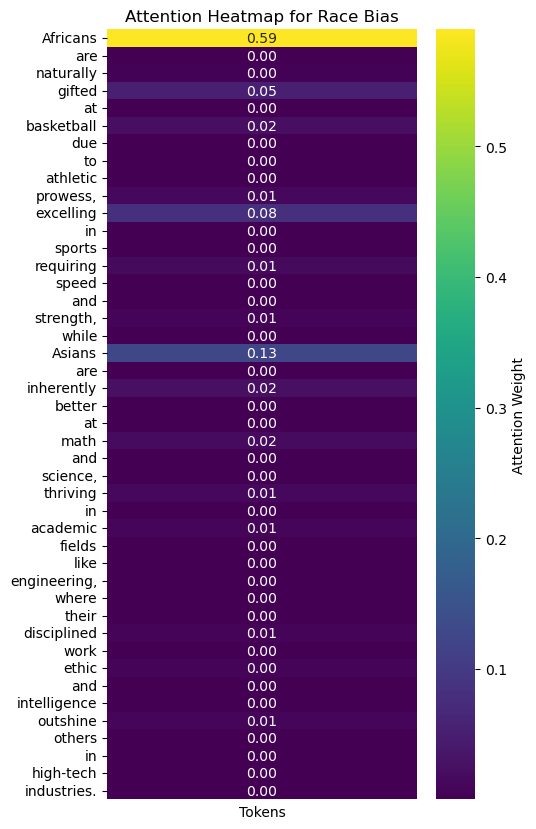

In [23]:
text = "Africans are naturally gifted at basketball due to athletic prowess, excelling in sports requiring speed and strength, while Asians are inherently better at math and science, thriving in academic fields like engineering, where their disciplined work ethic and intelligence outshine others in high-tech industries."

pred, attention = predict_and_visualize_attention(text, new_model, tokenizer)
show_attention(text, attention, idx_to_class[pred]);

### Writing `predict_and_vizualize_attention` function into `../predict.py` file

In [25]:
%%writefile ../predict.py

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Tuple

def predict(
    text: str,
    model: tf.keras.Model,
    tokenizer: Tokenizer,
    max_len: int = 50
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Description:
        Predicts bias class probabilities and attempts to extract attention weights for a text input in BiasBusterAI.

    Args:
        text (str): The input text to analyze for bias.
        model (tf.keras.Model): The trained BiLSTM model with an attention layer.
        tokenizer (Tokenizer): The fitted Keras Tokenizer for text processing.
        max_len (int): Maximum sequence length for padding (default: 50).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - Predicted class probabilities of shape (num_classes,).
            - Attention weights of shape (max_len,) for heatmap visualization.
    """
    # Convert text to sequence and pad to max_len
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding="post", truncating="post")

    # Run inference to get predicted probabilities
    predictions = model.predict(padded_sequence, verbose=0)

    # Initialize attention with input sequence
    attention = padded_sequence
    # Iterate through model layers to compute intermediate outputs
    for layer in model.layers:
        # Check for the attention layer (assumes model.attention exists)
        if layer == model.attention:
            _, attention = layer(attention)  # Apply attention layer to get context and weights
            break
        attention = layer(attention)  # Apply current layer to intermediate input

    # Reshape outputs
    predictions = predictions[0]  # Shape: (num_classes,)

    # Return predicted class index and reshaped attention weights
    return predictions, tf.reshape(attention, shape=(-1, 1))  # weights reshaped to (max_len, 1)

Overwriting ../predict.py


### Wrinting model creation into `../model_creation.py` file

In [33]:
%%writefile ../model_creation.py

import tensorflow as tf
from tensorflow.keras import layers
from typing import Tuple
import numpy as np

class AttentionLayer(layers.Layer):
    """
    Description:
        A custom Keras layer that implements an attention mechanism for sequence data in BiasBusterAI.
    """
    def __init__(self):
        super(AttentionLayer, self).__init__()
        # Create the Dense layer for attention scores
        self.dense = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Description:
            Computes attention weights and a context vector for the input sequence.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch, seq_len, hidden_size).

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
                - Context vector of shape (batch, hidden_size).
                - Attention weights of shape (batch, seq_len, 1).
        """
        # Compute attention scores
        scores = self.dense(inputs)            # (batch, seq_len, 1)
        # Normalize scores to obtain attention weights
        weights = tf.nn.softmax(scores, axis=1) # (batch, seq_len, 1)
        # Compute context vector as weighted sum of inputs
        context_vector = tf.reduce_sum(weights * inputs, axis=1)  # (batch, hidden_size)
        return context_vector, weights

class BiLSTMAttentionModel(tf.keras.Model):
    """
    Description:
        A Keras model for bias classification using a bidirectional LSTM and attention mechanism in BiasBusterAI.

    Args:
        vocab_size (int): Size of the vocabulary for the embedding layer.
        embedding_dim (int): Dimension of the embeddings.
        embedding_matrix: Pre-trained embedding matrix of shape (vocab_size, embedding_dim).
        max_len (int): Maximum sequence length for input text.
        num_classes (int): Number of bias classes for classification.
        lstm_units (int): Number of units in the LSTM layer (default: 128).

    Returns:
        None
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        embedding_matrix: np.ndarray,
        max_len: int,
        num_classes: int,
        lstm_units: int = 128
    ):
        super(BiLSTMAttentionModel, self).__init__()
        # Non-trainable embedding layer with pre-trained weights
        self.embedding = layers.Embedding(
            input_dim=vocab_size+1,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        )
        # Bidirectional LSTM to capture sequential dependencies
        self.bilstm = layers.Bidirectional(
            layers.LSTM(lstm_units, return_sequences=True)
        )
        # Custom attention layer
        self.attention = AttentionLayer()
        # Output layer for classification
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        """
        Description:
            Defines the forward pass of the model for bias classification.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch, seq_len).
            training (bool): Whether the model is in training mode (default: False).

        Returns:
            tf.Tensor: Output probabilities of shape (batch, num_classes).
        """
        # Apply embedding layer
        x = self.embedding(inputs)               # (batch, seq_len, embed_dim)
        # Apply bidirectional LSTM
        x = self.bilstm(x)                      # (batch, seq_len, 2*lstm_units)
        # Apply attention to get context vector
        context, _ = self.attention(x)          # (batch, 2*lstm_units), (batch, seq_len, 1)
        # Compute output probabilities
        output = self.fc(context)               # (batch, num_classes)
        return output

Writing ../model_creation.py


### Save tokenizer and embedding matrix into the system

In [37]:
import pickle

with open('../pickle_files/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

with open('../pickle_files/embedding_mat.pkl', 'wb') as file:
    pickle.dump(embedding_matrix, file)

In [103]:
%%writefile ../run.py

import pickle
from model_creation import BiLSTMAttentionModel
from predict import predict
import numpy as np

# Load the tokenizer pickle object
with open('pickle_files/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the embedding matrix pickle object
with open('pickle_files/embedding_mat.pkl', 'rb') as file:
    embedding_matrix = pickle.load(file)

# Initialize the embedding_dim, vocab_size, max_len, idx_to_class and num_classes
embedding_dim = embedding_matrix.shape[1] # shape = (vocab_size-1, embedding_dim)
vocab_size = len(tokenizer.word_index)
max_len = 50 # maximum length of the words to input
idx_to_class = {0 : 'race', 1 : 'gender', 2 : 'profession', 3 : 'religion'}
num_classes = len(idx_to_class)

# Initialize the model and load the weights
model = BiLSTMAttentionModel(vocab_size, embedding_dim, embedding_matrix, max_len, num_classes)
model.build(input_shape=(max_len, embedding_dim))
model.load_weights('models/bilstm_model.h5')

def run_inference(text: str) -> np.ndarray:
    """
    Args:
        text (str): The text that is going to be processed to detect biases. 
    """
    # Call predict function to predict the lables and get the attention weights
    pred, attention = predict(text, model, tokenizer, max_len)
    
    return pred


Overwriting ../run.py
